In [107]:
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline
warnings.filterwarnings('ignore')


In [108]:
# Read In Data
basic = pd.read_csv("name.basics.tsv", sep = '\t')
principal = pd.read_csv("title.principals.tsv", sep = '\t', error_bad_lines=False)
rating = pd.read_csv("title.ratings.tsv", sep = '\t')
movie = pd.read_csv("title.basics.tsv", sep = '\t', error_bad_lines=False)

In [109]:
# Clean Data 1
# Replace null-like strings with nulls
movie = movie.replace('\\N', np.nan)
# Filter out no start year
movie = movie[movie['startYear'].isnull()==False] # very limited number of cases and not many votes
movie['startYear'] = movie['startYear'].apply(int) # convert to int
movie = movie[(movie['titleType']=='movie') & # movies only, no shorts, misc
              (movie['isAdult'] == 0) & # no adult
              (movie['startYear'] >= 2000) & # imdb launched in 1990 and internet did not take off till much later
              (movie['startYear'] <= 2017) # Future releases not relevant to scoring
             ]
# merge with rating
movie = movie.merge(rating, on ='tconst')

#### Big Assumption 1: Limit movies to those with a count of ratings over 200. 
First of all, I am wary of the vulnerability of these scores to trolls and friends/family. Also, it is difficult to know the quality of this data. So votes can be a proxy for vetted data. Finally, data transformations and model training will be faster for you!

In [110]:
# Based on Assumption 1
movie = movie[movie['numVotes']>200]

In [111]:
# Clean Data 2

# EDA of principals eased by reducing data set to those films above
principal = principal[principal['tconst'].isin(movie['tconst'].unique())]
basic = basic[basic['nconst'].isin(principal.nconst.unique())]

#### Big Assumption 2: - Movie rating can be predicted from the historical performance of the people involved.
Historical performance of people involved is limited by our data set. We will make simplifying assumptions - contributions of the people IMDB lists as principals are all those involved and their historical performance should be weighted equally. We will use a simple average of the last 5 years of films.

In [112]:
# Based on Assumption 2

components = principal.merge(basic,
                             on='nconst').merge(movie[['averageRating',
                                                       'numVotes',
                                                       'startYear',
                                                       'tconst']], on='tconst')
components = components[['tconst', 'nconst', 'averageRating', 'startYear', 'numVotes']]
components = components.merge(components, on='nconst')
grouped = components[(components['tconst_x'] != components['tconst_y']) &  # remove dupe movie relations
                     (components['startYear_x'] > components['startYear_y']) &  # base movie data cannot include future
                     ((components['startYear_x'] - components['startYear_y']) < 6)  # prior movies within 5 years
                     ].groupby('tconst_x').agg({'averageRating_y': 'mean',
                                                'numVotes_y': 'mean'})
avg_5_year = grouped[['numVotes_y', 'averageRating_y']].reset_index()
avg_5_year.columns = ['tconst', 'prior_votes', 'prior_rating']

#### Background Assumption in 2: We are ignoring that ratings change over time.
Our assumptions in 2 above, that we should only use prior movies to predict a given
movie rating ignores the fact that the ratings we have been influenced by later released movies.
That is, The Fellowship of The Ring may have subsequently received better ratings because
of how great The Return of the King was, etc. However, if we were building a model to predict all movies on IMBD rating tomorrow, the best predictor would be the current rating. 
That is not very interesting. What we are really interested in is predicting what rating
movie an unreleased movie would receive in its first few years, or until its rating stabilized

In [114]:
# Finalize Features for Modeling
fw = movie.merge(avg_5_year, on ='tconst') # historic team performance
fw = fw[fw['startYear']>2004] # remove movies where hist team performance is not available
to_remove = ['titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'endYear', 'numVotes', 'rating_bin', 'vote_bins']
to_use = [x for x in fw.columns.tolist() if x not in to_remove]
fw = fw[to_use]
# remove one movie without a genre
fw = fw[~fw['genres'].isnull()]
# Get categorical features from genre
fw['genres'] = fw['genres'].apply(lambda x: x.split(','))
fw = fw.join(pd.get_dummies(fw['genres'].apply(pd.Series).stack()).sum(level=0))
# Convert year to a metric more posed to capturing difference between early
# and later mainstream use of IMDB
fw['years_from_2000'] = fw['startYear'].apply(lambda x: x-2000)
# clearing 447 examples without a runtime
fw = fw[~fw['runtimeMinutes'].isnull()]
fw['runtimeMinutes'] = fw['runtimeMinutes'].apply(int)
# Movie is now the index
fw = fw.set_index('tconst')
# dropping features used to derive other features
fw = fw.drop(['startYear', 'genres'], axis=1)

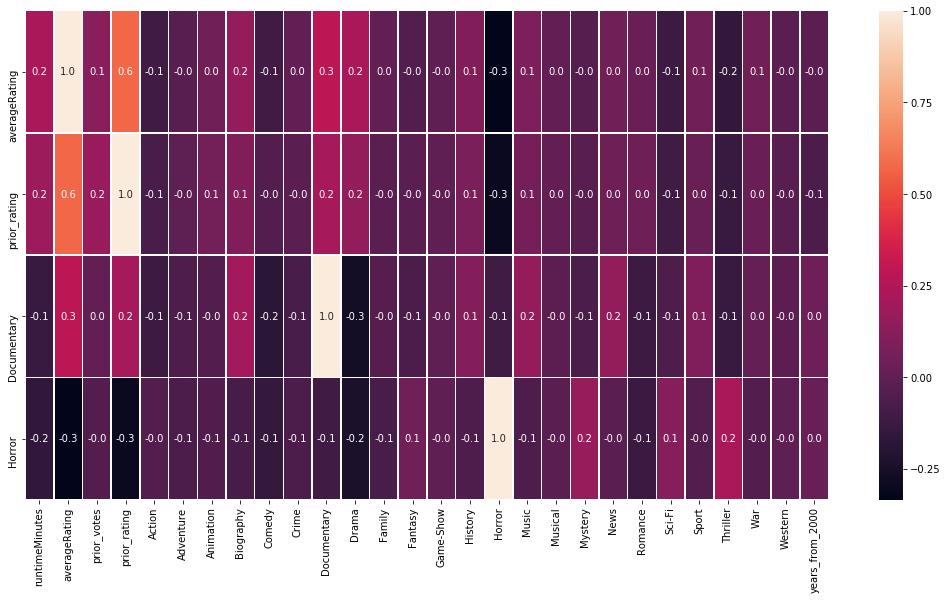

In [115]:
# Visualize feature correlations
viz = pd.DataFrame(StandardScaler().fit_transform(fw))
viz.columns = fw.columns
viz_cor = viz.corr()
f, ax = plt.subplots(figsize=(18, 9))
sns.heatmap(viz_cor[(viz_cor['averageRating']< -.25) |
       (viz_cor['averageRating']> .25)], annot=True, linewidths=.5, fmt='.1f', ax=ax)
plt.show()

It appears rating history is very correlated to our target predictor (averageRating) as well as horror and documentary genres.

In [117]:
# Test train split before grid search
X_train, X_test, y_train, y_test = train_test_split(
fw.loc[:, fw.columns != 'averageRating'], fw['averageRating'], random_state=0)
# xgboost is having issues with column names (it renames)
X_train = X_train.values
X_test = X_test.values

In [118]:
# Set up machine learning pipeline (though ended up not using pre-processing)
pipe = Pipeline([ ('regressor', RandomForestRegressor(n_jobs=4))])
# Hyperparameter grid, the tuning examples here reflects a positive direction I found after a few passes
param_grid = [
              {'regressor': [RandomForestRegressor(n_jobs=4,
                                                     n_estimators=150,
                                                     random_state=0)],
               #'preprocessing': [None],
               'regressor__max_features': ['auto'],
               'regressor__max_depth': [5, 10],
               'regressor__min_samples_split': [2, 5]},
              {'regressor': [XGBRegressor(n_jobs=4,
                                            learning_rate=.1,
                                            n_estimators=150,
                                            verbosity=2)],
               #'preprocessing': [None],
               'regressor__max_depth': [3],
               'regressor__min_child_weight': [6, 10, 12],
               'regressor__gamma': [0]}]


In [134]:
%%time 
# Spray and Pray modeling - setting scoring method
# Gridsearchcv will automatically refit on the entire train set with the model and
# parameter configuration that best performs..
# This should take less than 1 minute
grid = GridSearchCV(pipe, param_grid, cv=3, scoring={'explained_variance': 'explained_variance', 
                                                      'r2': 'r2', 
                                                      'neg_mean_squared_error': 'neg_mean_squared_error'}, 
                    refit='neg_mean_squared_error', verbose=1)
# Reminder - we are fitting on the undersampled training data
grid.fit(X_train, y_train)

In [120]:
# Best performer
grid.best_estimator_.named_steps["regressor"]

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=10, missing=None, n_estimators=150,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=2)

In [123]:
# Performance

# Dumb average of ratings of training data
for_baseline = DummyRegressor().fit(X=X_train,y=y_train)
baseline_mse = mean_squared_error(y_test, for_baseline.predict(X_test))
print("Baseline MSE: %.4f" % baseline_mse)
# Model Performance
model_mse = mean_squared_error(y_test, grid.predict(X_test))
print("Model MSE: %.4f" % model_mse)
print("Model Improvement Over baseline: %.2fx" %(baseline_mse/model_mse))

Baseline MSE: 1.5871
Model MSE: 0.8190
Model Improvement Over baseline: 1.94x


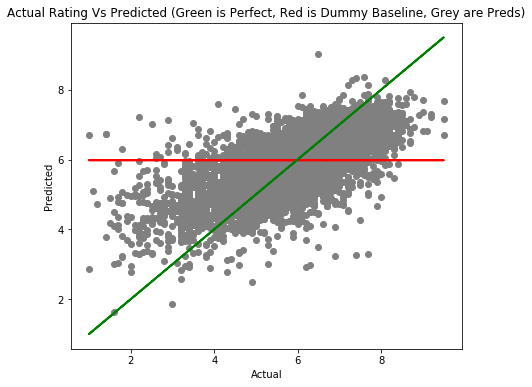

In [124]:
plt.figure(figsize=(7, 6))
plt.title('Actual Rating Vs Predicted (Green is Perfect, Red is Baseline(Avg), Grey is Model)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.scatter(y_test,  grid.predict(X_test),  color='grey')
plt.plot(y_test, for_baseline.predict(X_test), color='red', linewidth=2)
plt.plot(y_test, y_test, color='green', linewidth=2)
plt.show()

In [125]:
# xgboost rewrites feature names 
feature_names = fw.loc[:, fw.columns != 'averageRating'].columns.tolist()
feature_names = [no_space.replace(" ", "") for no_space in feature_names ]

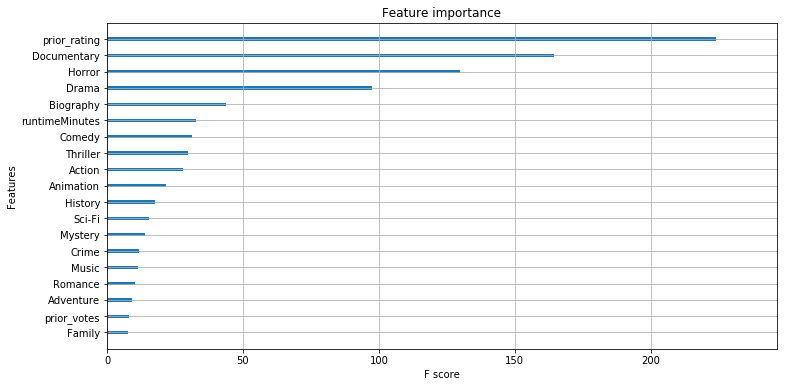

In [131]:
# xgboost feature importance ranker, by gain (https://xgboost.readthedocs.io/en/latest/R-package/discoverYourData.html)
grid.best_estimator_.named_steps["regressor"].get_booster().feature_names = feature_names
f, ax = plt.subplots(figsize=(12, 6))
xgb.plot_importance(grid.best_estimator_.named_steps["regressor"].get_booster(),
                    max_num_features = 19,
                    show_values = False,
                    importance_type='gain',
                    ax=ax)
plt.show()

Features: As expected based on the correlation heatmap, ratings recieved by the principals in films made prior to a given movie was the strongest feature, followed by Documentary and Horror generes. I was not expecting prior_votes to have such a low relative importance.  

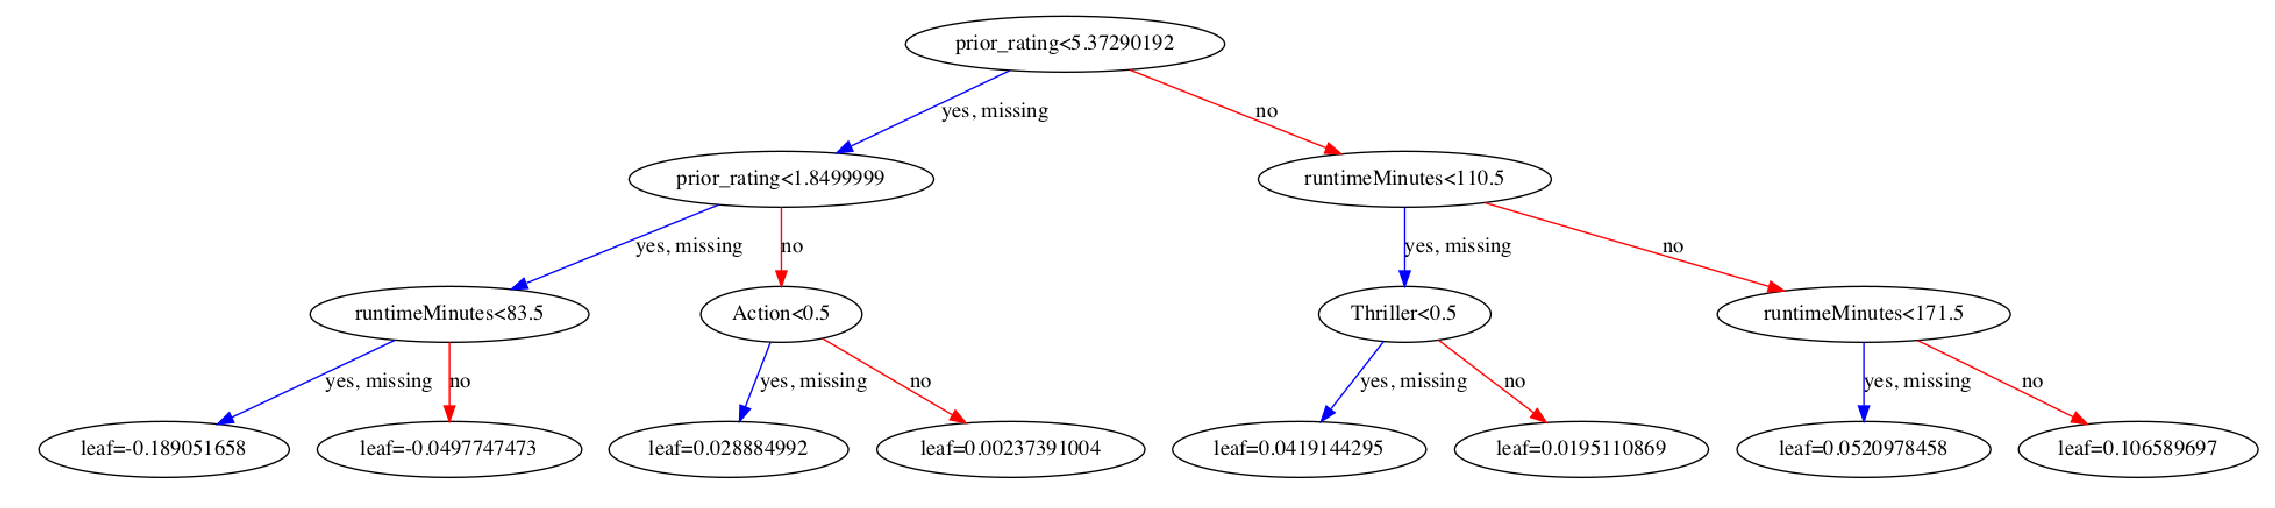

In [129]:
# xgboost tree visualization, see how features interact
# blue direction is for when a node meets the condition
# https://xgboost.readthedocs.io/en/latest/tutorials/model.html
# we can potentially improve our model by constraining spurious interactions: 
# https://xgboost.readthedocs.io/en/latest/tutorials/feature_interaction_constraint.html
fig, ax = plt.subplots(figsize=(40, 80))
xgb.plot_tree(grid.best_estimator_.named_steps["regressor"].get_booster(),num_trees=25, ax=ax)
plt.show()

In sum, compared against a dumb average, our model performs well, but I certainly wouldn't use it to make business decisions. We are quite limited by the IMDB data set and this analysis leaves a lot of information out by ignoring the differences between contributors (principals). It also ignores any sense of a time-series trend or relationship to similar films (other than by principals or genre). I would love to spend time understanding the hype cycles associated with certain actors or the longevity of different strong intellectual properties. When it comes to audible I search out narrators I love as well as specific content. I think ratings impact my decisions most when it comes to narration. There's so much pre-analysis that goes into identifying content, but audible is the only place where the narration is evaluated in my experience. I'm very interested to understand how different demographics or listener clusters (perhaps around content) respond to narrators.